# Libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import *

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
    
import keract
import networkx as nx
from collections import deque, defaultdict
import sklearn
from sklearn import preprocessing
from typing import TypedDict, Optional, Union
from pprint import pprint
from grandalf.layouts import SugiyamaLayout
import grandalf
from PIL import Image

from pathlib import Path
import seaborn as sns
from tqdm import tqdm

# import onnx
# from onnx_tf.backend import prepare
# from onnx2keras import onnx_to_keras
# from onnx2tf import convert


# Dataset

2023-02-21 15:05:31.140946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


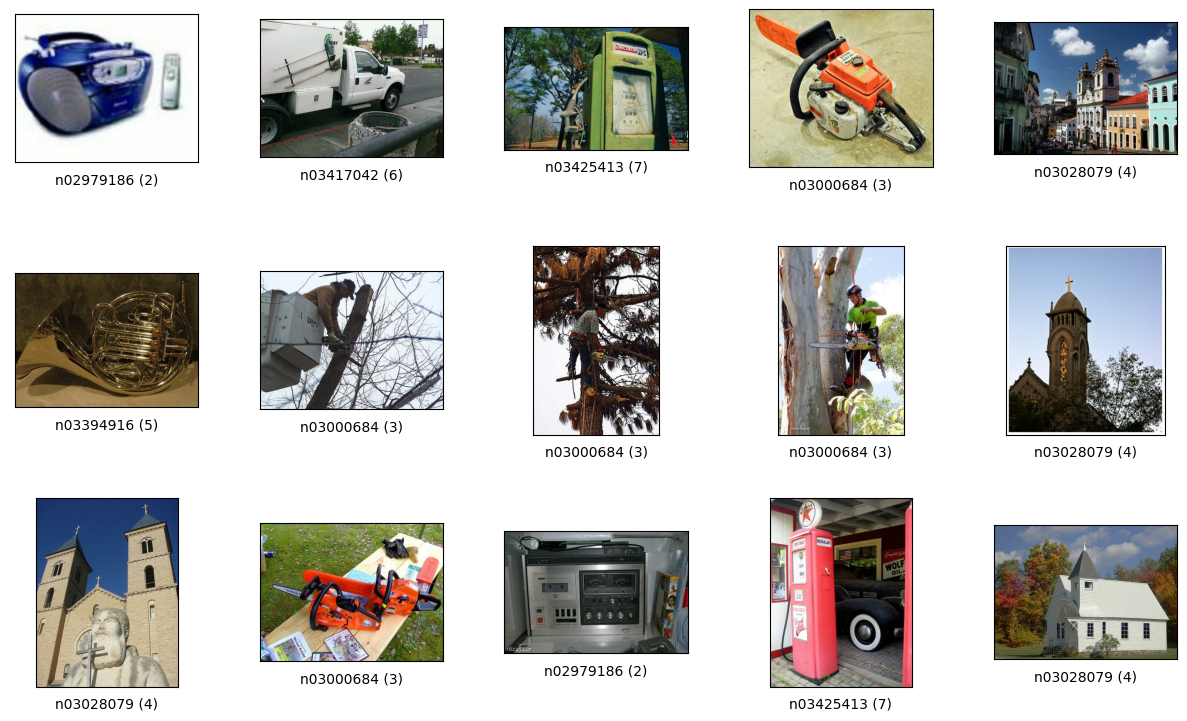

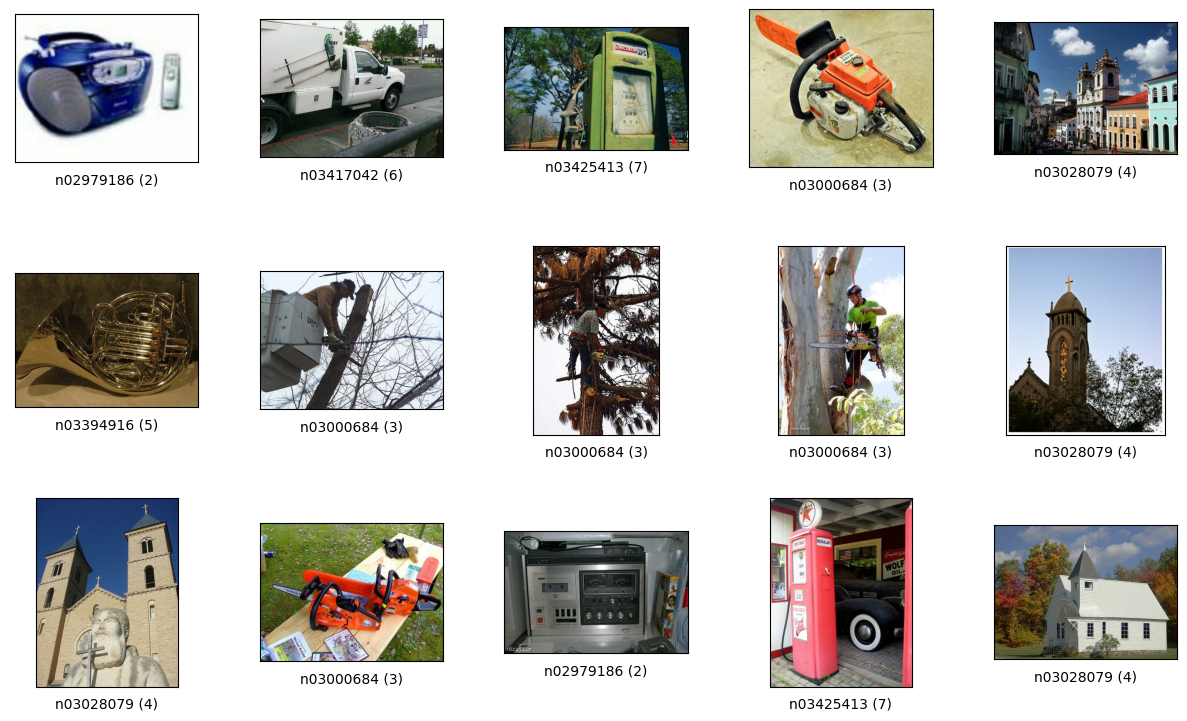

In [2]:
ds_and_info : tuple[defaultdict, tfds.core.DatasetInfo] = tfds.load(
    'imagenette/320px-v2', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/My 4TB 2/Big Data/tensorflow_datasets'
)

ds, ds_info = ds_and_info

tfds.show_examples(ds['train'], ds_info, cols=5)

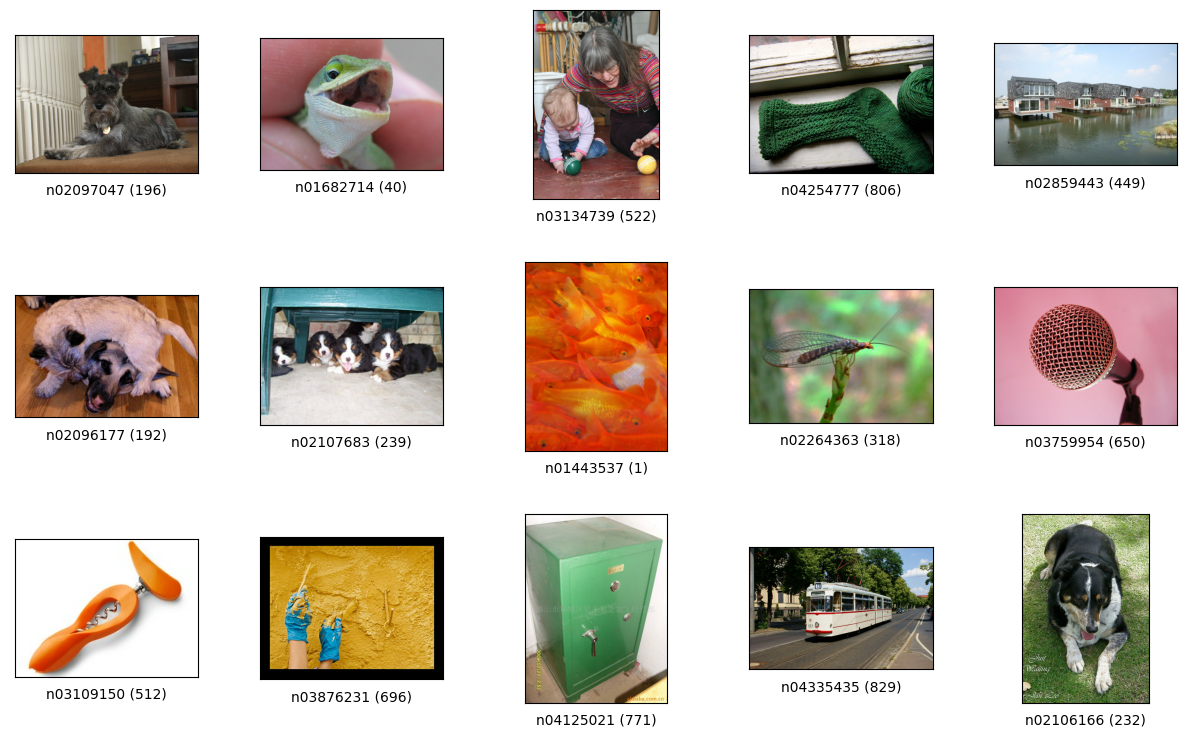

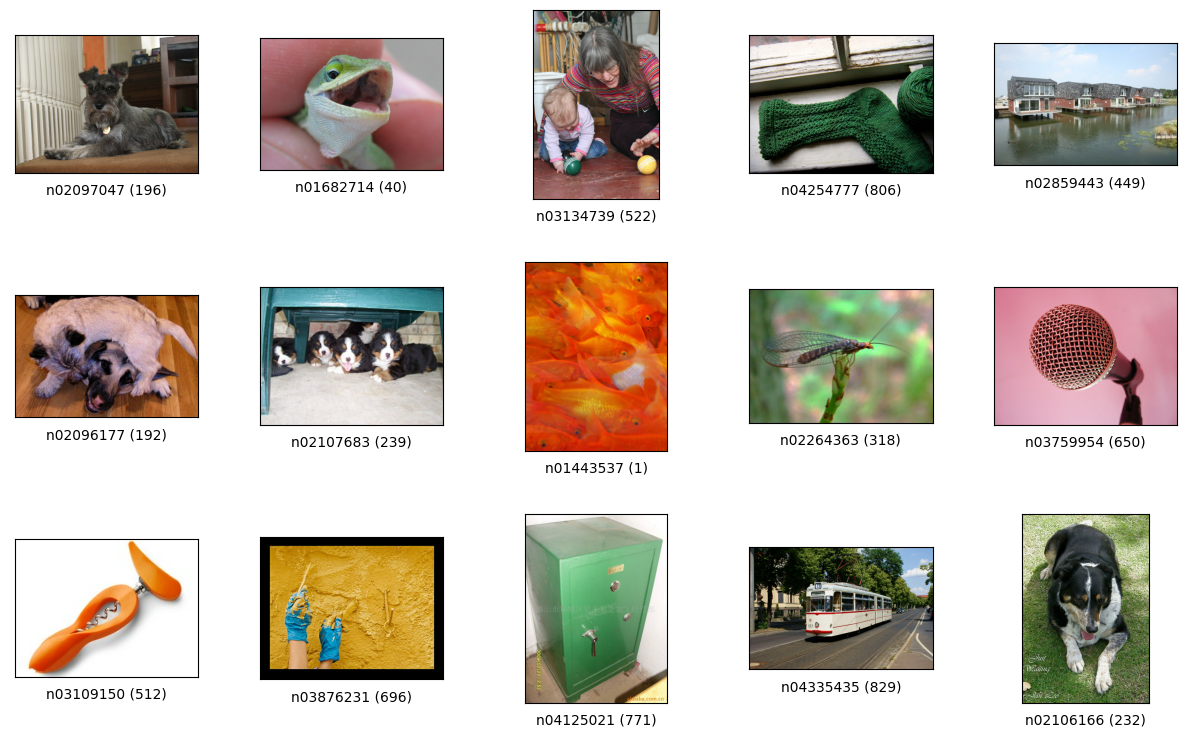

In [3]:
ds_and_info : tuple[defaultdict, tfds.core.DatasetInfo] = tfds.load(
    'imagenet2012', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/My 4TB 2/Big Data/tensorflow_datasets'
)

ds, ds_info = ds_and_info

tfds.show_examples(ds['train'], ds_info, cols=5)

In [4]:
for image, label in ds['train'].shuffle(100):
    print(image.shape)
    print(ds_info.features['label'].names[label])
    break

(375, 500, 3)
n04004767


In [5]:
ds_info.features['label'].shape

()

# Inception V3

![Inceptionv3_architecture.png](Inceptionv3_architecture.png)

In [6]:
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)
inception_v3.compile(loss="categorical_crossentropy", optimizer="adam")

vgg = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)

vgg.compile(loss="categorical_crossentropy", optimizer="adam")

model = vgg


In [7]:
def create_model_zip(model, model_name: str = None, output_dir: Union[str, Path] = '.'):
    def zip_dir(dir: Union[Path, str], filename: Union[Path, str]):
        """Zip the provided directory without navigating to that directory using `pathlib` module"""
        dir = Path(dir)

        with zipfile.ZipFile(filename, "w", zipfile.ZIP_DEFLATED) as zip_file:
            for entry in dir.rglob("*"):
                zip_file.write(entry, entry.relative_to(dir))

    output_dir = Path(output_dir)
    if not model_name:
        model_name = model.name

    model.save('/tmp/'+model_name)
    zip_dir('/tmp/'+model_name, output_dir.joinpath(model_name+'.zip'))
    print("Now you can upload the model from current directory to APalysis")

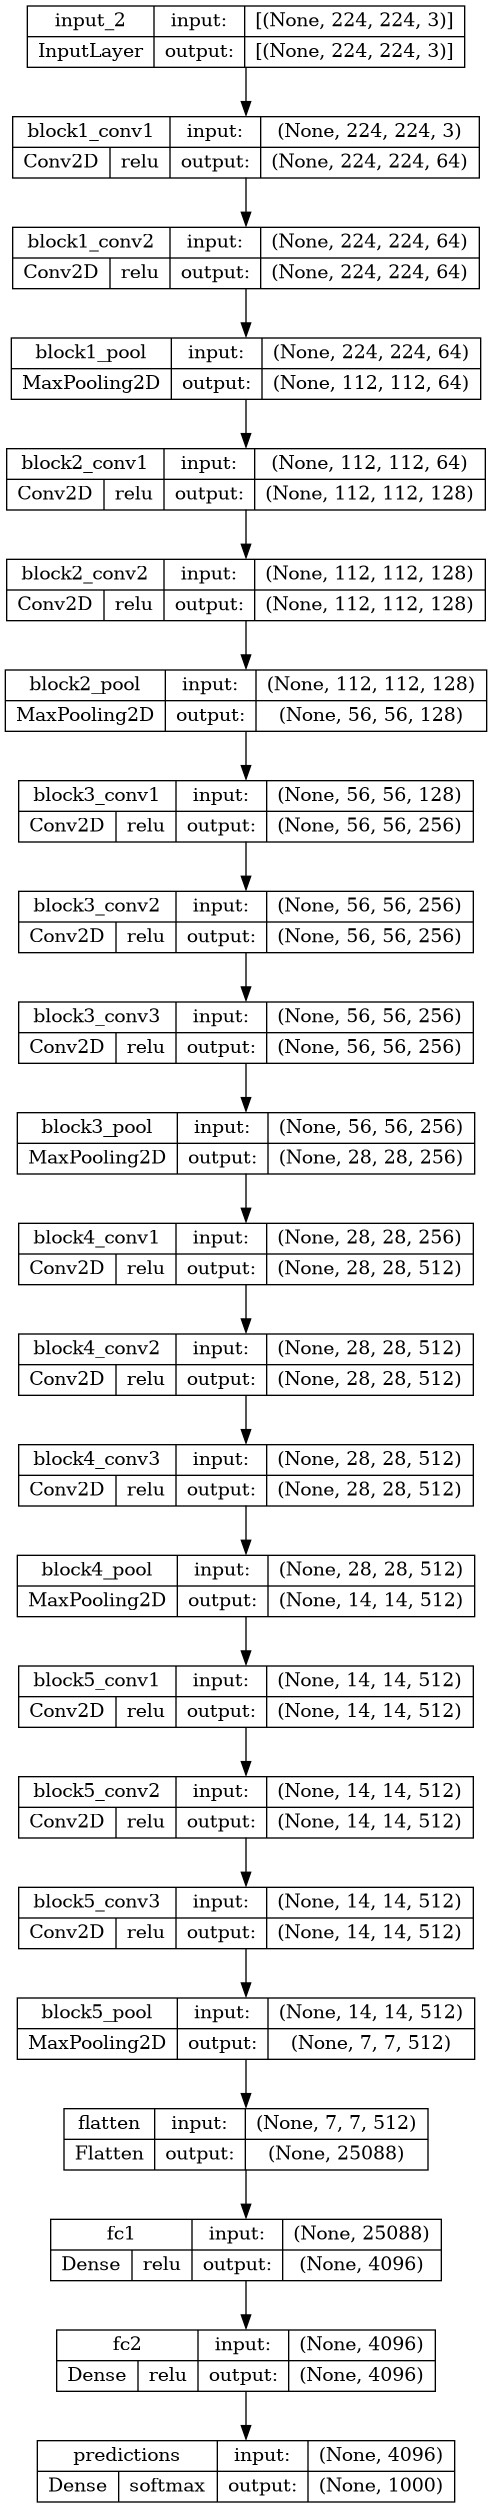

In [8]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True,
    # show_dtype=True,
    # expand_nested=True,
    show_layer_activations=True
)

# Get Activation Pathways

In [9]:
activation_pathway_full = model_to_graph(model)

In [10]:
names = set()

for node, node_data in activation_pathway_full.nodes(data=True):
    names.add(node_data['layer_type'])

names

{'Conv2D', 'Dense', 'Flatten', 'InputLayer', 'MaxPooling2D'}

In [11]:
simple_activation_pathway_full = remove_intermediate_node(activation_pathway_full, lambda node: activation_pathway_full.nodes[node]['layer_type'] not in ['Conv2D', 'Dense', 'InputLayer', 'Concatenate'])

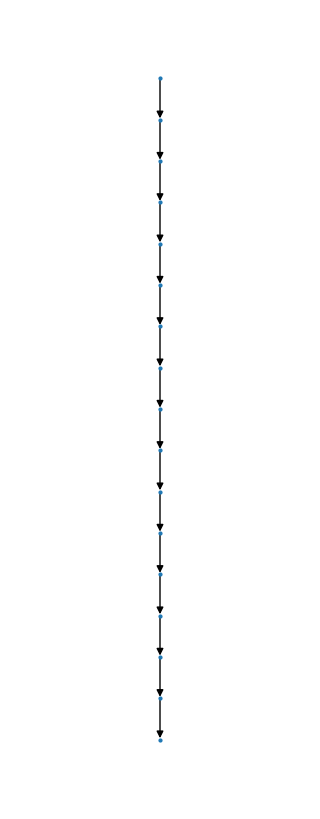

In [12]:
def get_model_layout(G):
    # TODO: Work on getting a better layout

    # Naive layout
    # pos = {}
    # input_node, _ = next(node for node in G.nodes(data=True) if node[1]['layer_type'] == 'InputLayer')
    # G.nodes[input_node]['level'] = 0
    # tree_depth = 0
    # for node in nx.topological_sort(G):
    #     if G.nodes[node]['layer_type'] == 'InputLayer':
    #         continue
    #     level = max(
    #         G.nodes[predecessor]['level'] 
    #         for predecessor in G.predecessors(node)
    #     ) + 1
    #     G.nodes[node]['level'] = level
    #     tree_depth = max(tree_depth, level)
    # pos = nx.multipartite_layout(G, subset_key="level", align='horizontal', scale=-1)


    # Get nodes by level
    # nodes_by_level = [[] for tree_depth in range(tree_depth + 1)]

    # for node, node_data in simple_activation_pathway_full.nodes(data=True):
    #     nodes_by_level[node_data['level']].append(node)

    # [[nx.get_node_attributes(simple_activation_pathway_full, 'name')[node] for node in nodes] for nodes in nodes_by_level]


    # Sugiyama Layout from grandalf library
    g = grandalf.utils.convert_nextworkx_graph_to_grandalf(G)
    for v in g.V(): v.view = type("defaultview", (object,), {"w": 10, "h": 10})
    sug = SugiyamaLayout(g.C[0])
    sug.init_all()
    sug.draw() # This only calculated the positions for each node.
    pos = {v.data: (v.view.xy[0], -v.view.xy[1]) for v in g.C[0].sV} # Extracts the positions
    return pos

plt.figure(figsize=(3,8))
nx.draw(simple_activation_pathway_full, pos=get_model_layout(simple_activation_pathway_full), node_size=4)
plt.show()

# Preprocessing

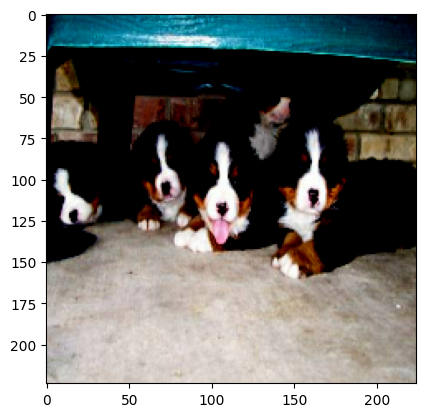

In [13]:
example_img, example_label = get_example(ds['train'])

example_img = preprocess(example_img, size=model.input.shape[1:3].as_list())
plt.imshow(example_img)

# Test Model Prediction

In [14]:
input_img: np.ndarray = tf.reshape(example_img, [1, *example_img.shape]).numpy()
pred: tf.Tensor = model(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True', class_id_to_name(ds_info.features['label'].names[example_label]))

Predicted mosquito_net
True Bernese_mountain_dog


# Get each layer output

In [15]:
input_img = Image.open("cat.jpg")
input_img = preprocess(input_img, size=model.input.shape[1:3].as_list())
input_img = tf.reshape(input_img, [1, *input_img.shape]).numpy()
pred = model(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True tabby')

Predicted Egyptian_cat
True tabby


In [16]:
# layers = ['conv2d_6', 'conv2d_93']
layers = None

activations = keract.get_activations(model, input_img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


In [82]:
summary_fn = lambda x: np.percentile(np.abs(x), 70, axis=range(len(x.shape)-1))
# summary_fn = lambda x: np.mean(np.abs(x), axis=tuple(range(len(x.shape)-1)))

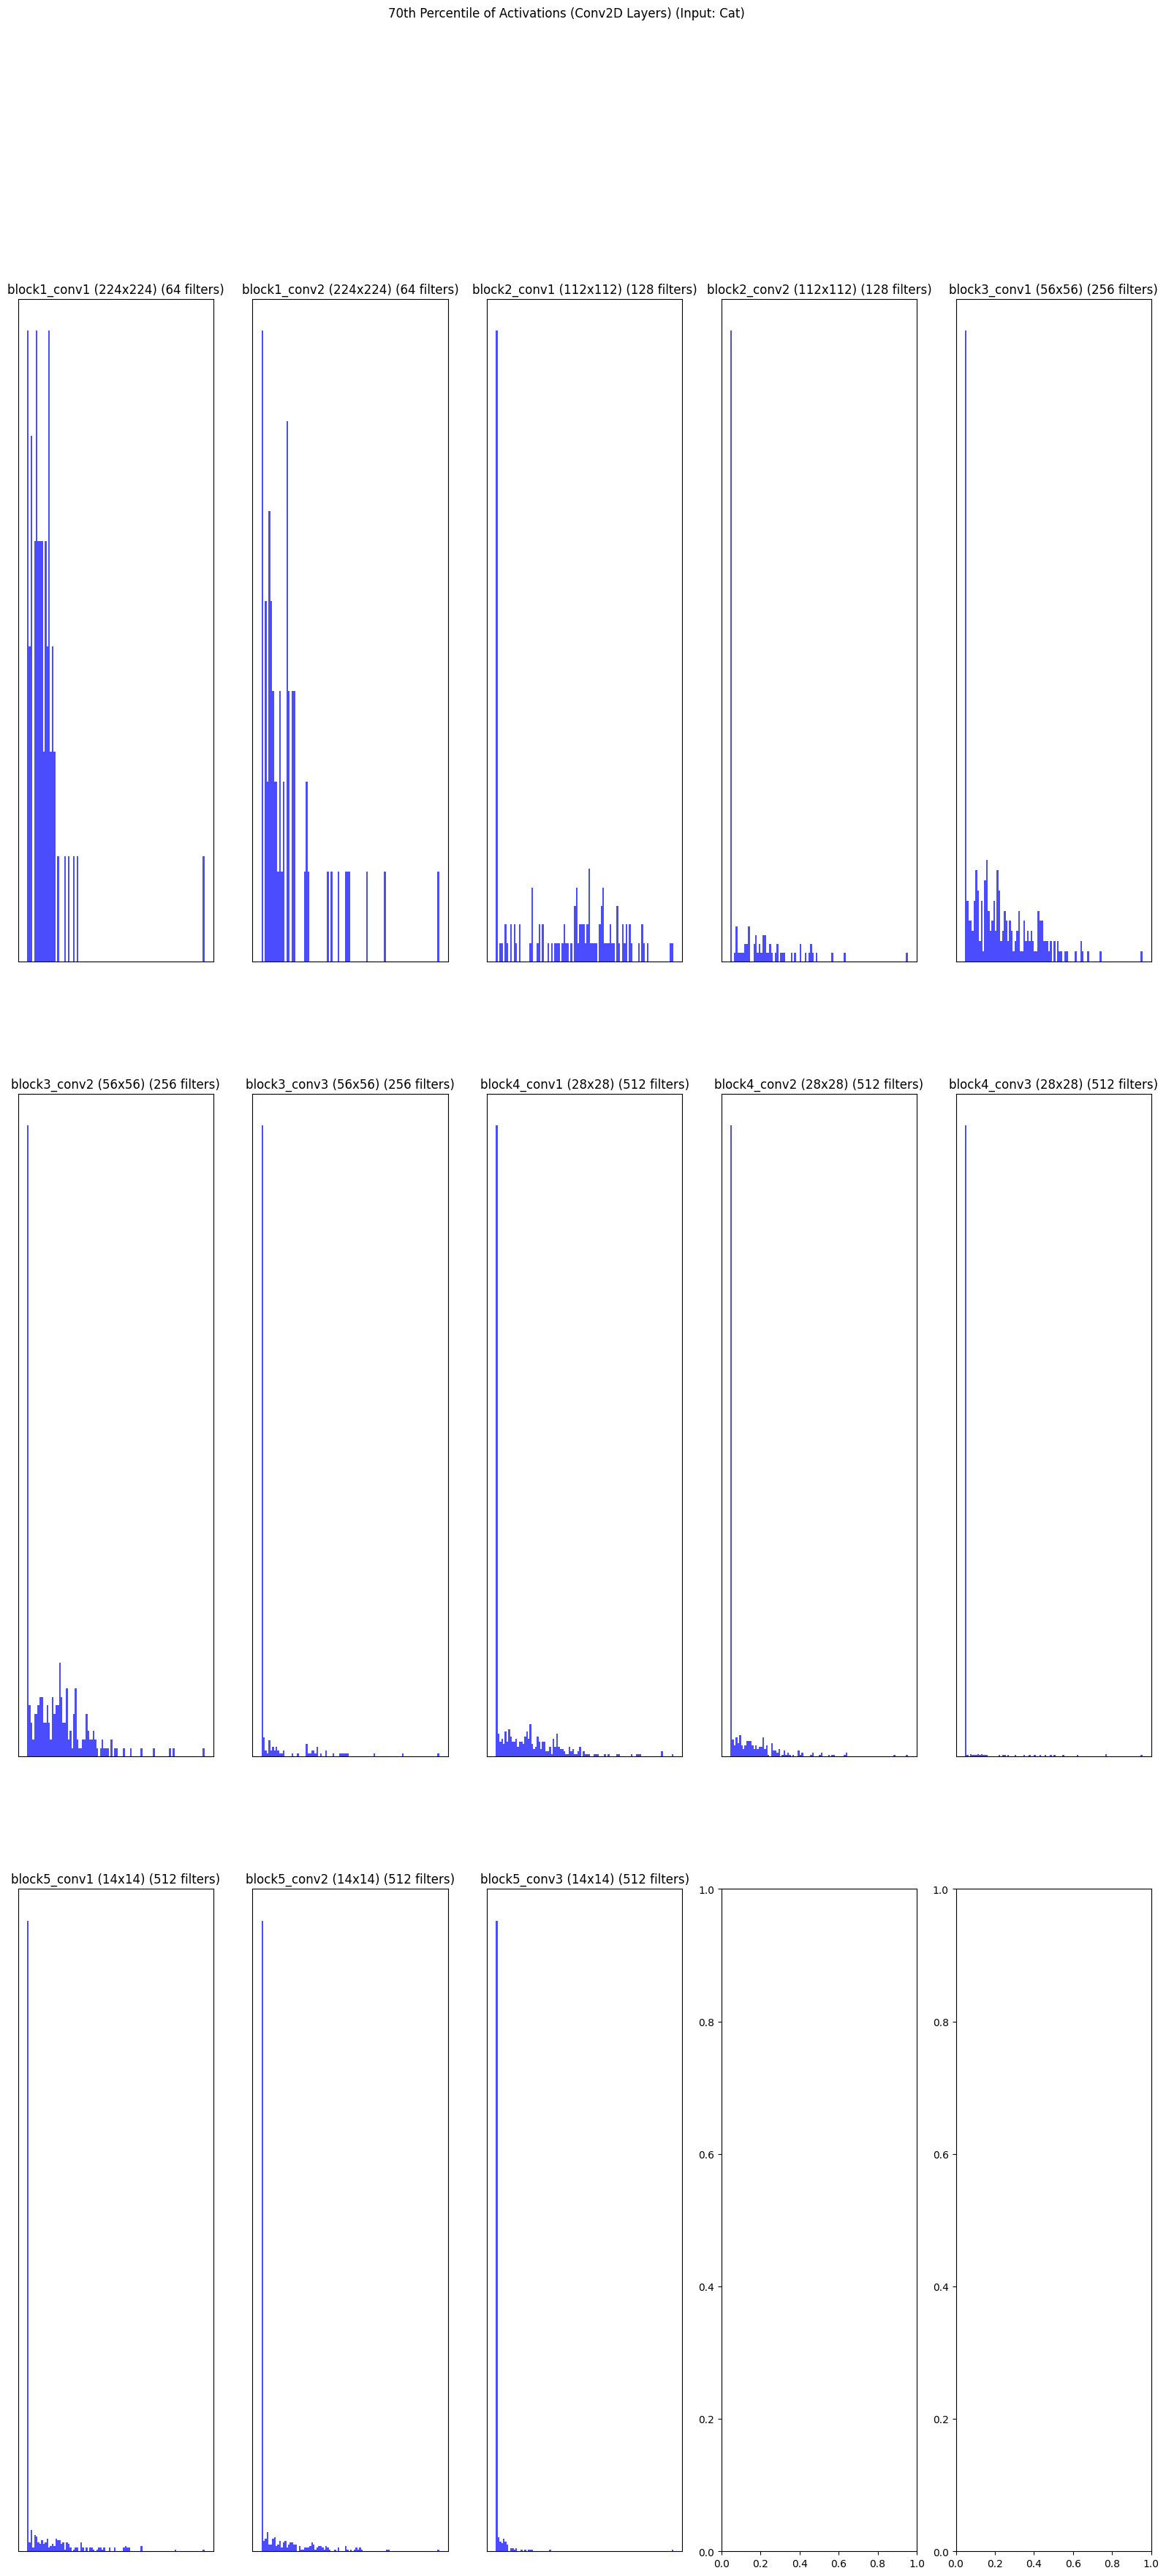

In [17]:
conv2D_activations = [layer for layer in activations if 'conv' in layer]

cols = 5
rows = len(conv2D_activations) // cols + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 40),
    # sharex=True,
    # sharey=True
)
axes = axes.flatten()
fig.suptitle("70th Percentile of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Mean of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Median of Activations (Conv2D Layers) (Input: Cat)")

for layer, ax in zip(conv2D_activations, axes):
    summary = summary_fn(activations[layer])
    ax.hist(summary, bins=100, color='blue', alpha=0.7)
    ax.set_title(f"{layer} ({activations[layer].shape[1]}x{activations[layer].shape[2]}) ({summary.shape[0]} filters)")

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/tmp/ipykernel_63472/3226390771.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)


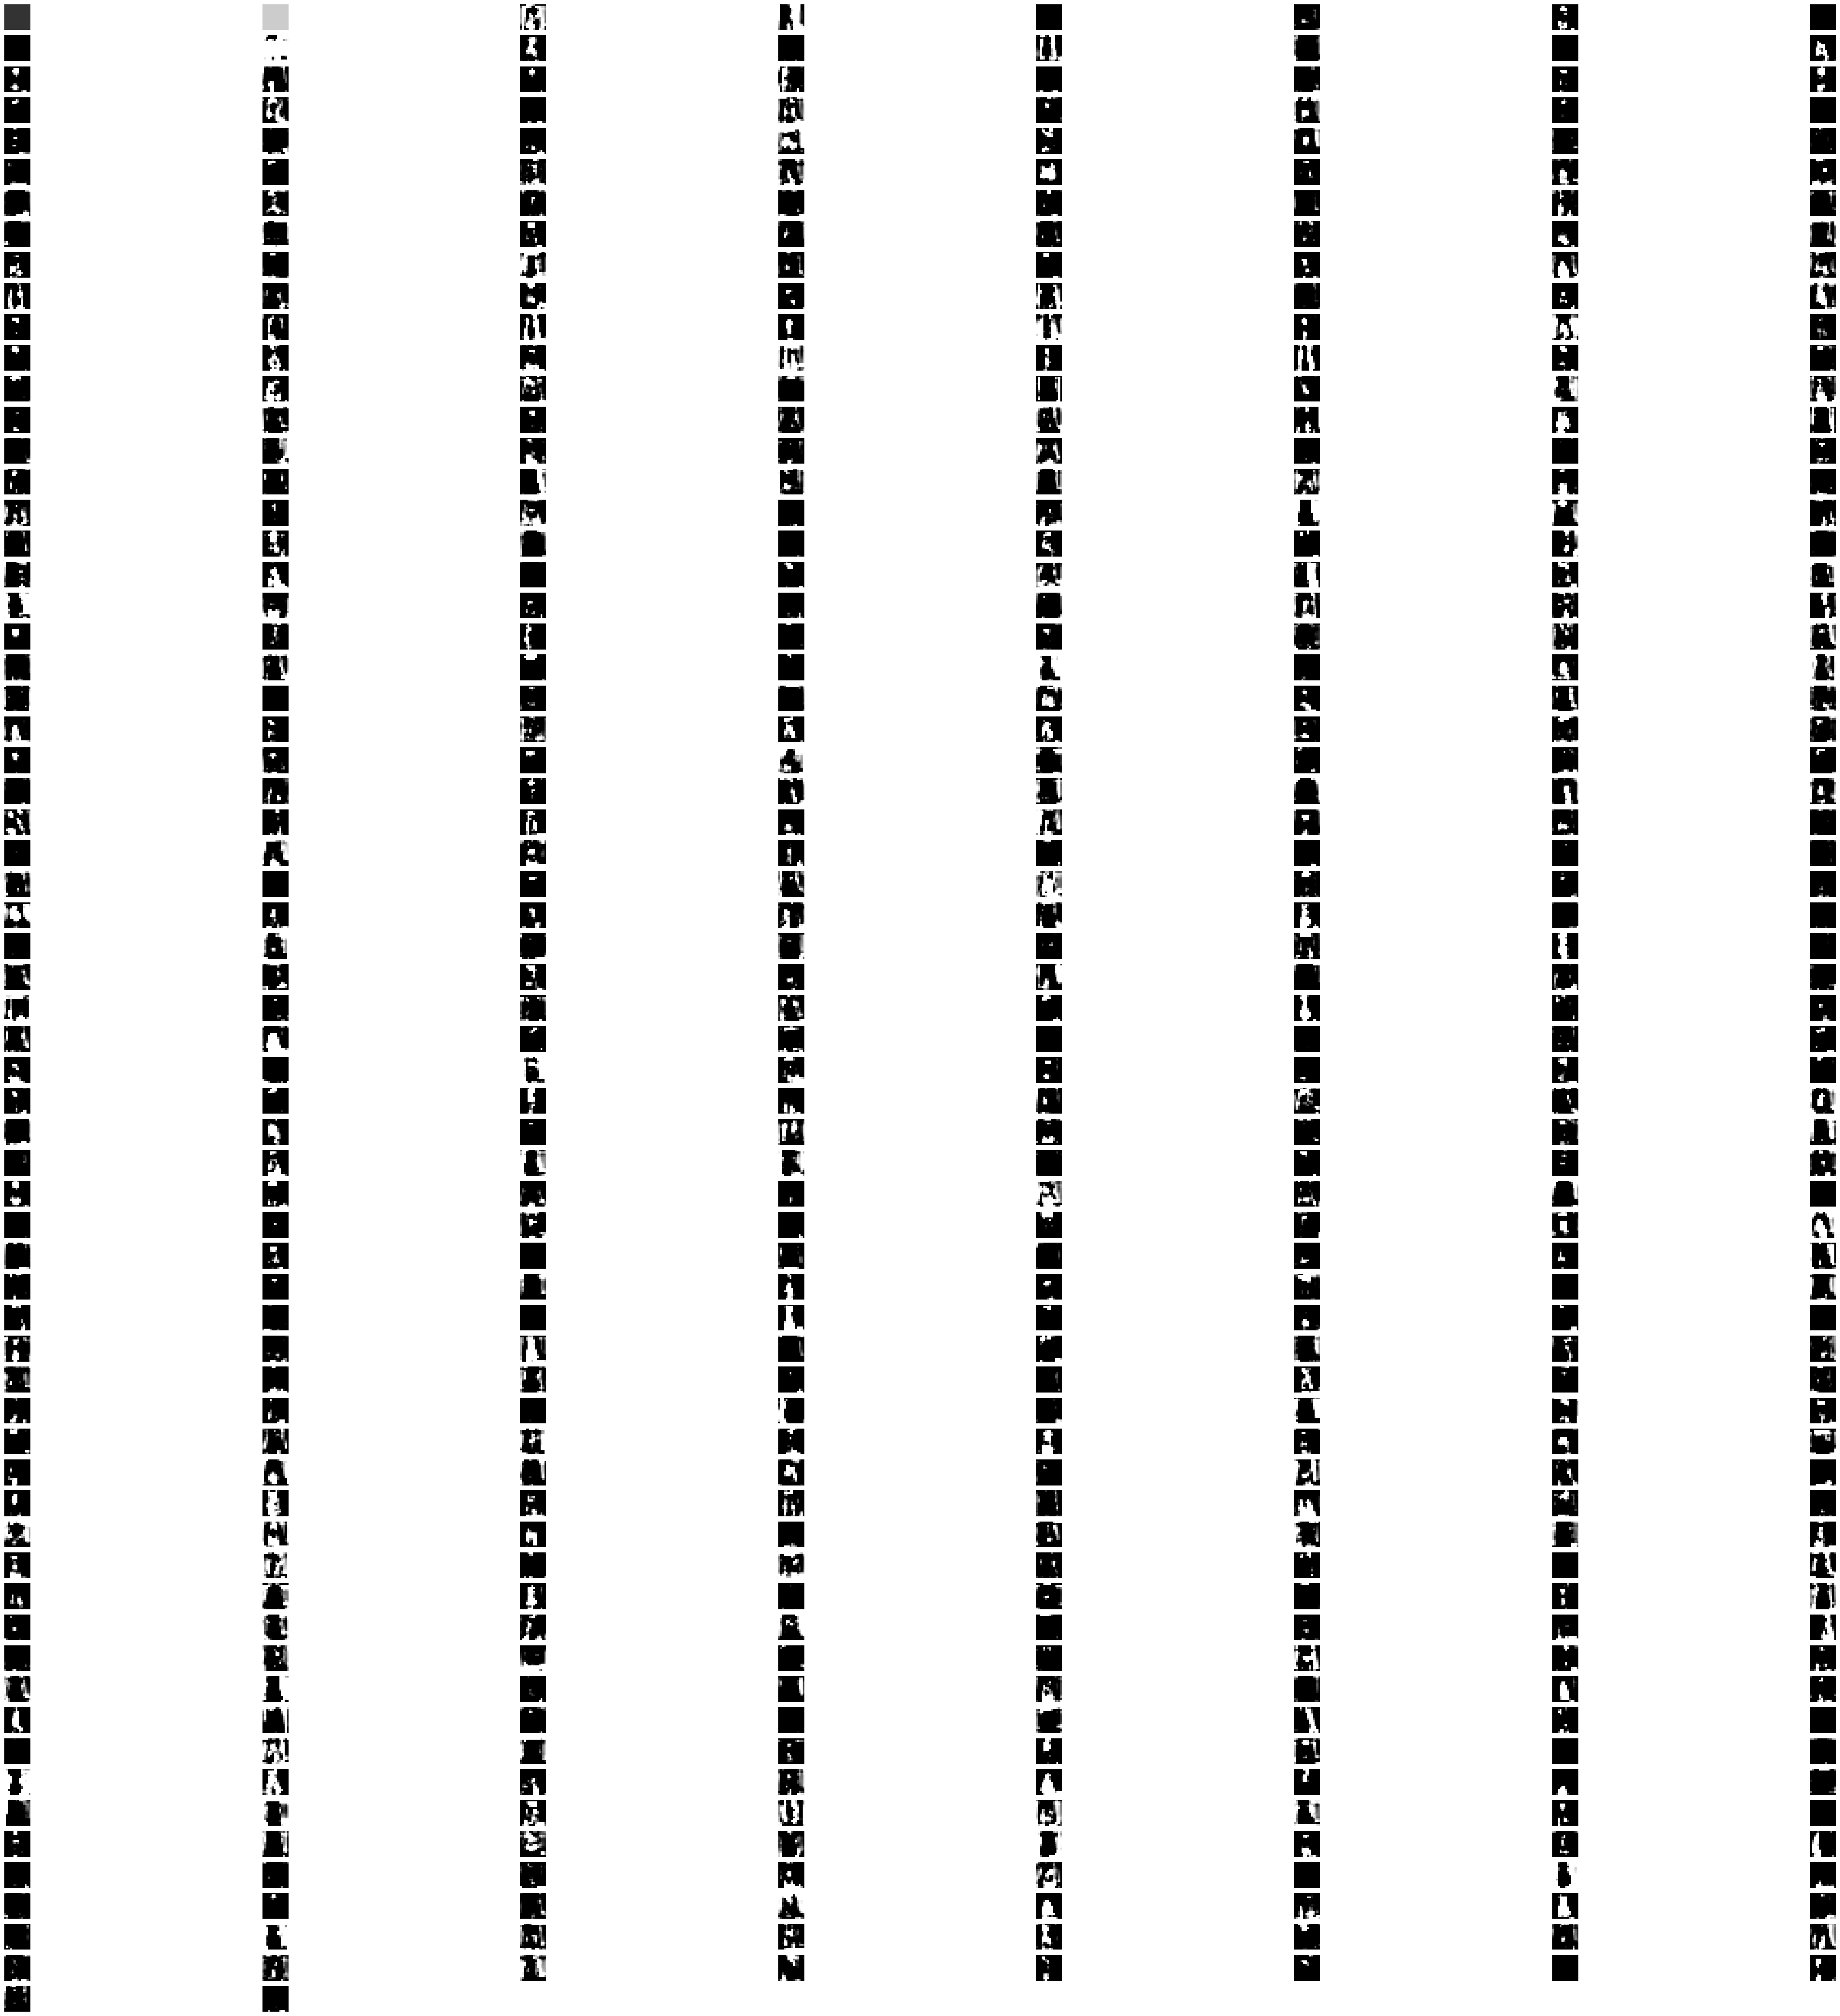

In [18]:
layer = 'block5_conv2'
nrows = 8
cur_activations = np.abs(activations[layer])
cur_activations = (cur_activations - np.percentile(cur_activations, 10)) / (np.percentile(cur_activations, 90) - np.percentile(cur_activations, 10))
cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)

# Plot all the images from layer in grid with nrows columns
fig, ax = plt.subplots(figsize=(60, 60))
for i in range(cur_activations.shape[3]):
    ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)
    ax.imshow(
        cur_activations[0,:,:,i],
        interpolation='nearest',
        cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.show()


/home/insane/.cache/pypoetry/virtualenvs/activation-pathway-bUO20rvG-py3.10/lib/python3.10/site-packages/keract/keract.py:486: RuntimeWarning: divide by zero encountered in divide
  scaled = arr * (1/(np.amax(arr) - np.amin(arr)))
/home/insane/.cache/pypoetry/virtualenvs/activation-pathway-bUO20rvG-py3.10/lib/python3.10/site-packages/keract/keract.py:486: RuntimeWarning: invalid value encountered in multiply
  scaled = arr * (1/(np.amax(arr) - np.amin(arr)))


block5_conv2 (1, 14, 14, 512) 


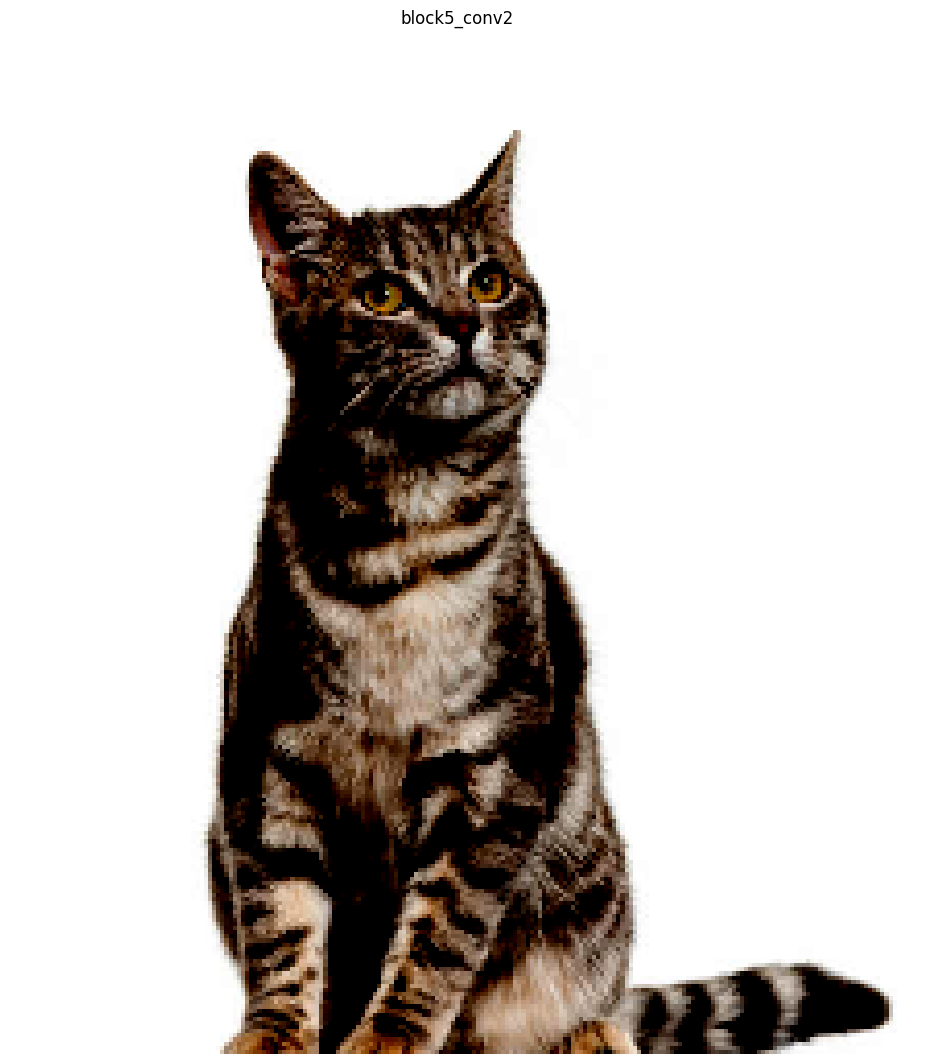

In [19]:
keract.display_heatmaps({layer: np.array([activations[layer][0]])}, input_img[0], fix=False, merge_filters=True)

# Filtering activation layers

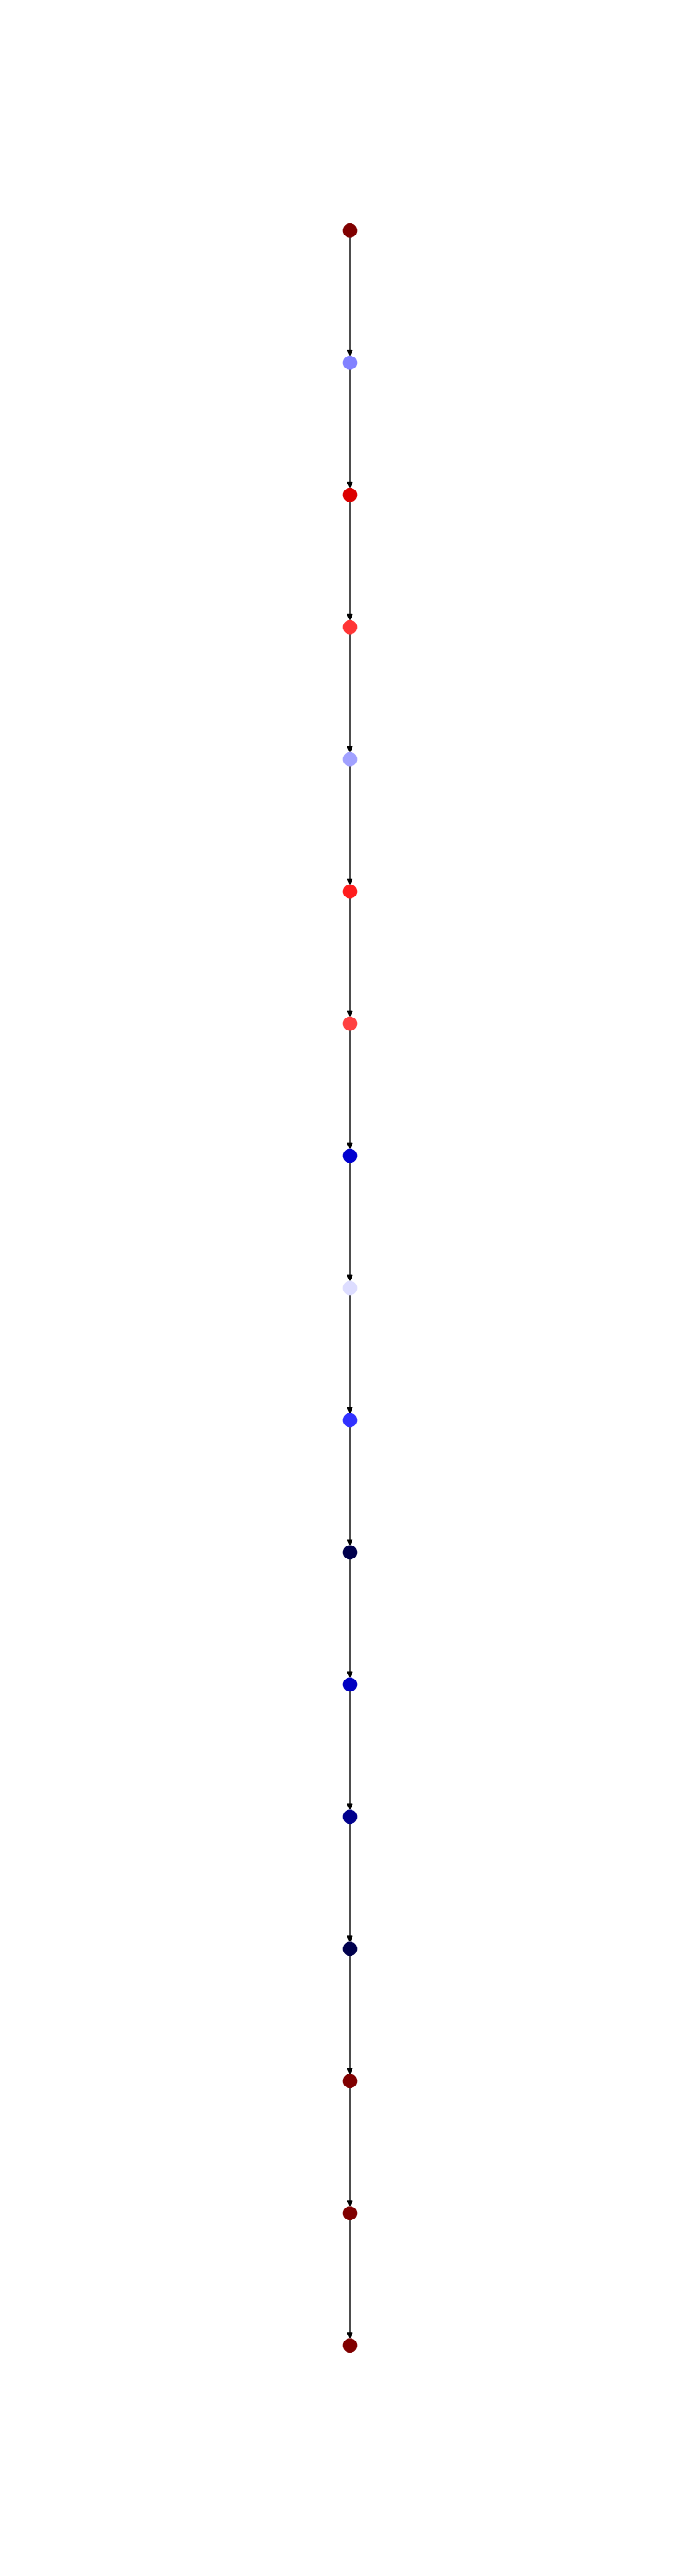

In [20]:
THRESHOLD = 0.5
TOP_BOT_CUT = 0

simple_activation_pathway_full_img1 = simple_activation_pathway_full.copy()

for node, data in simple_activation_pathway_full_img1.nodes(data=True):
    if 'conv' in data['name'] or 'mixed' in data['name']:
        cur_activations = activations[data['name']]
        # cur_activations = np.clip((cur_activations - np.percentile(cur_activations, TOP_BOT_CUT)) / (np.percentile(cur_activations, 100 - TOP_BOT_CUT) - np.percentile(cur_activations, TOP_BOT_CUT)), 0, 1)
        values = summary_fn(cur_activations)

        dynamic_threshold = np.percentile(values, 100 * THRESHOLD)

        # values = values > dynamic_threshold
        values = values > THRESHOLD

        simple_activation_pathway_full_img1.nodes[node]['activated'] = values
    else:
        simple_activation_pathway_full_img1.nodes[node]['activated'] = np.array([True])


plt.figure(figsize=(8,30))
activated_count = np.array([data['activated'].sum()/len(data['activated']) for node, data in simple_activation_pathway_full_img1.nodes(data=True)])
activated_count = (activated_count - activated_count.min()) / (activated_count.max() - activated_count.min())

cmap = list(map(mpl.colormaps['seismic'], activated_count))
nx.draw(
    simple_activation_pathway_full_img1,
    pos=get_model_layout(simple_activation_pathway_full_img1),
    node_size=120,
    node_color=cmap,
    # labels=nx.get_node_attributes(simple_activation_pathway_full_img1, 'name'),
    # connectionstyle="arc3,rad=0.1"
)
plt.show()

['input_2   1/1', 'block1_conv1   26/64', 'block1_conv2   53/64', 'block2_conv1   91/128', 'block2_conv2   56/128', 'block3_conv1   188/256', 'block3_conv2   179/256', 'block3_conv3   57/256', 'block4_conv1   251/512', 'block4_conv2   170/512', 'block4_conv3   24/512', 'block5_conv1   105/512', 'block5_conv2   68/512', 'block5_conv3   24/512', 'fc1   1/1', 'fc2   1/1', 'predictions   1/1']


/tmp/ipykernel_63472/2341248753.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


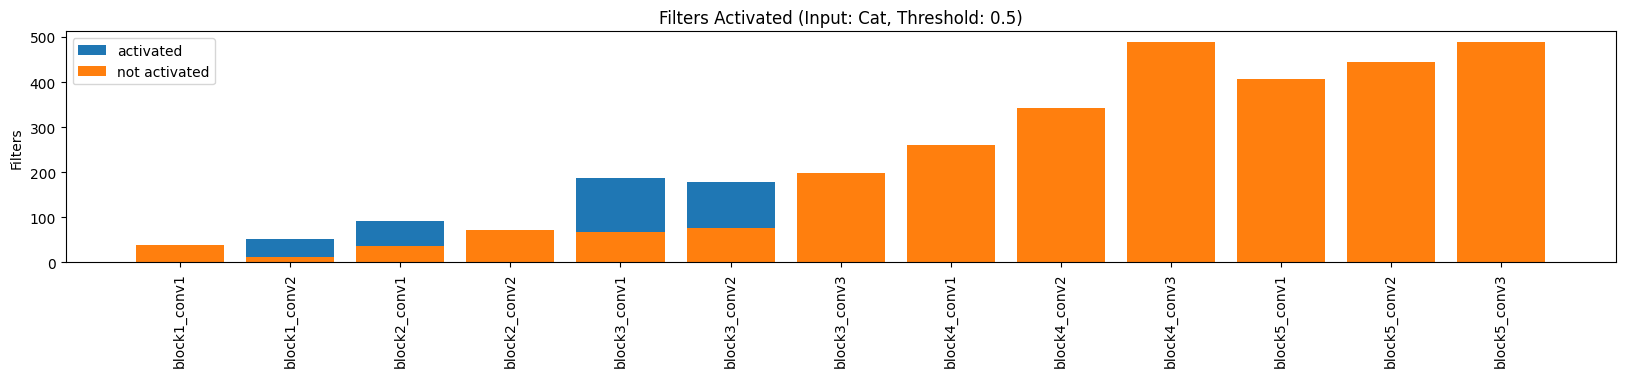

In [21]:
print([f"{data['name']}   {data['activated'].sum()}/{len(data['activated'])}" for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data])
activated = {data['name']: (data['activated'].sum(), len(data['activated'])-data['activated'].sum()) for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data}

conv2D_activated = {k: v for k, v in activated.items() if 'conv' in k}

labels = [k for k in conv2D_activated.keys()]
activated = [v[0] for v in conv2D_activated.values()]
deactivated = [v[1] for v in conv2D_activated.values()]

fig, ax = plt.subplots(figsize=(20, 3))
ax.bar(labels, activated, label="activated")
ax.bar(labels, deactivated, label="not activated")
ax.set_ylabel("Filters")
ax.set_xticklabels(labels, rotation=90)
ax.set_title(f"Filters Activated (Input: Cat, Threshold: {THRESHOLD})")
ax.legend()
plt.show()

In [22]:
def compare_activation_layer(layer1_activation_summary, layer2_activation_summary):
    return np.sqrt(((layer1_activation_summary - layer2_activation_summary)*(layer1_activation_summary - layer2_activation_summary)).sum())

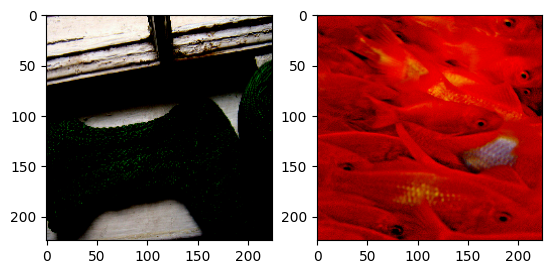

806 1


In [23]:
example_img1, example_label1 = get_example(ds['train'])
example_img2, example_label2 = get_example(ds['train'])

example_img1 = preprocess(example_img1, size=model.input.shape[1:3].as_list())
example_img2 = preprocess(example_img2, size=model.input.shape[1:3].as_list())
plt.subplot(121)
plt.imshow(example_img1)
plt.subplot(122)
plt.imshow(example_img2)
plt.show()

print(example_label1, example_label2)

510.0621396384653


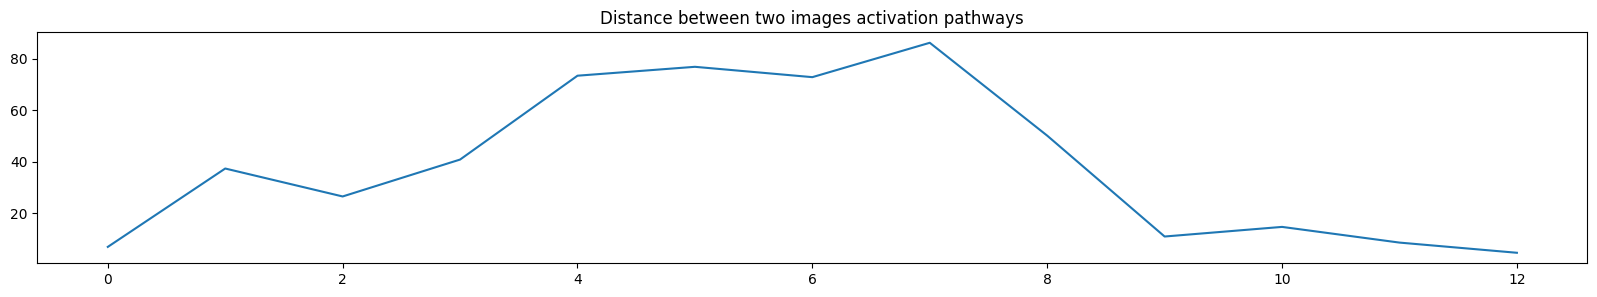

In [24]:
layers = None

activations1 = keract.get_activations(model, np.array([example_img1]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
activations2 = keract.get_activations(model, np.array([example_img2]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


dist = {f"{i_name}-{j_name}": compare_activation_layer(summary_fn(layer_i), summary_fn(layer_j)) for i_name, layer_i in activations1.items() for j_name, layer_j in activations2.items() if ('conv' in i_name or 'mixed' in i_name) and i_name == j_name}

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dist.values())
# ax.set_ylim(0, 10)
ax.set_title("Distance between two images activation pathways")
print(sum(dist.values()))

In [25]:
dist

{'block1_conv1-block1_conv1': 6.999062930139871,
 'block1_conv2-block1_conv2': 37.374189531348634,
 'block2_conv1-block2_conv1': 26.543685016405533,
 'block2_conv2-block2_conv2': 40.84665297863198,
 'block3_conv1-block3_conv1': 73.34722750966476,
 'block3_conv2-block3_conv2': 76.79247947055151,
 'block3_conv3-block3_conv3': 72.78208851602834,
 'block4_conv1-block4_conv1': 86.10686255085872,
 'block4_conv2-block4_conv2': 50.11819873457056,
 'block4_conv3-block4_conv3': 11.01977086155977,
 'block5_conv1-block5_conv1': 14.747190708862604,
 'block5_conv2-block5_conv2': 8.66685174231956,
 'block5_conv3-block5_conv3': 4.717879087523394}

# Get summary for whole dataset

In [27]:
processed_ds = ds['train'].map(
    lambda x,y: preprocess((x,y), size=model.input.shape[1:3].as_list()),
)
processed_ds = processed_ds.batch(32)
processed_ds = processed_ds.prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:
layers = list(filter(lambda l: 'conv' in l or 'mixed' in l, map(lambda l: l.name, model.layers)))

for img_batch, label_batch in processed_ds:
    activations = keract.get_activations(vgg, img_batch, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
    print(activations[layers[0]].shape)
    print(summary_fn(activations[layers[0]]).shape)
    # pred = inception_v3.predict(img_batch)
    # print(np.sum(pred.argmax(axis=1) == label_batch.numpy()))
    break

(32, 224, 224, 64)
(32, 64)


In [30]:
for image, label in ds['train']:
    print(image.shape)
    print(label)
    break

(375, 500, 3)
tf.Tensor(196, shape=(), dtype=int64)


In [31]:
{layer.name: layer.input_shape[-1] for layer in model.layers if 'conv' in layer.name}

{'block1_conv1': 3,
 'block1_conv2': 64,
 'block2_conv1': 64,
 'block2_conv2': 128,
 'block3_conv1': 128,
 'block3_conv2': 256,
 'block3_conv3': 256,
 'block4_conv1': 256,
 'block4_conv2': 512,
 'block4_conv3': 512,
 'block5_conv1': 512,
 'block5_conv2': 512,
 'block5_conv3': 512}

In [32]:
np.moveaxis(activations[layer][0], 2, 0).shape

(512, 14, 14)

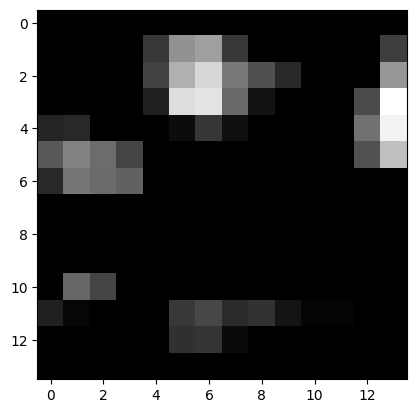

In [33]:
plt.imshow(np.moveaxis(activations[layer][0], 2, 0)[0], cmap='gray')

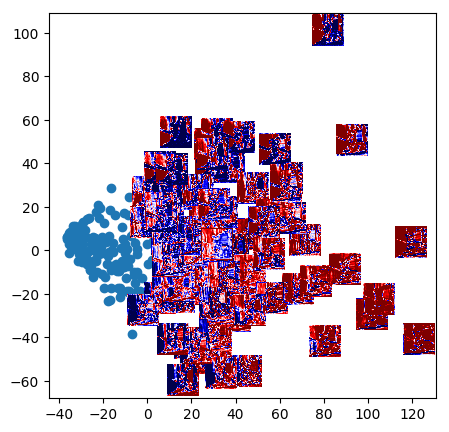

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

LOW_PERCENT = 10
HIGH_PERCENT = 90
img_size_zoom = 0.4
threshold = 7
thresholded = summary_fn(np.array([activations[layer][0]]))[0] > threshold

layer = 'block3_conv1'

data = np.moveaxis(activations[layer][0], 2, 0)
train = data.reshape((data.shape[0], -1))
train = StandardScaler().fit_transform(train)

pca = PCA(n_components=2)
pca_res = pca.fit_transform(train)
x = pca_res[:,0]
y = pca_res[:,1]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

0.0 108.33243


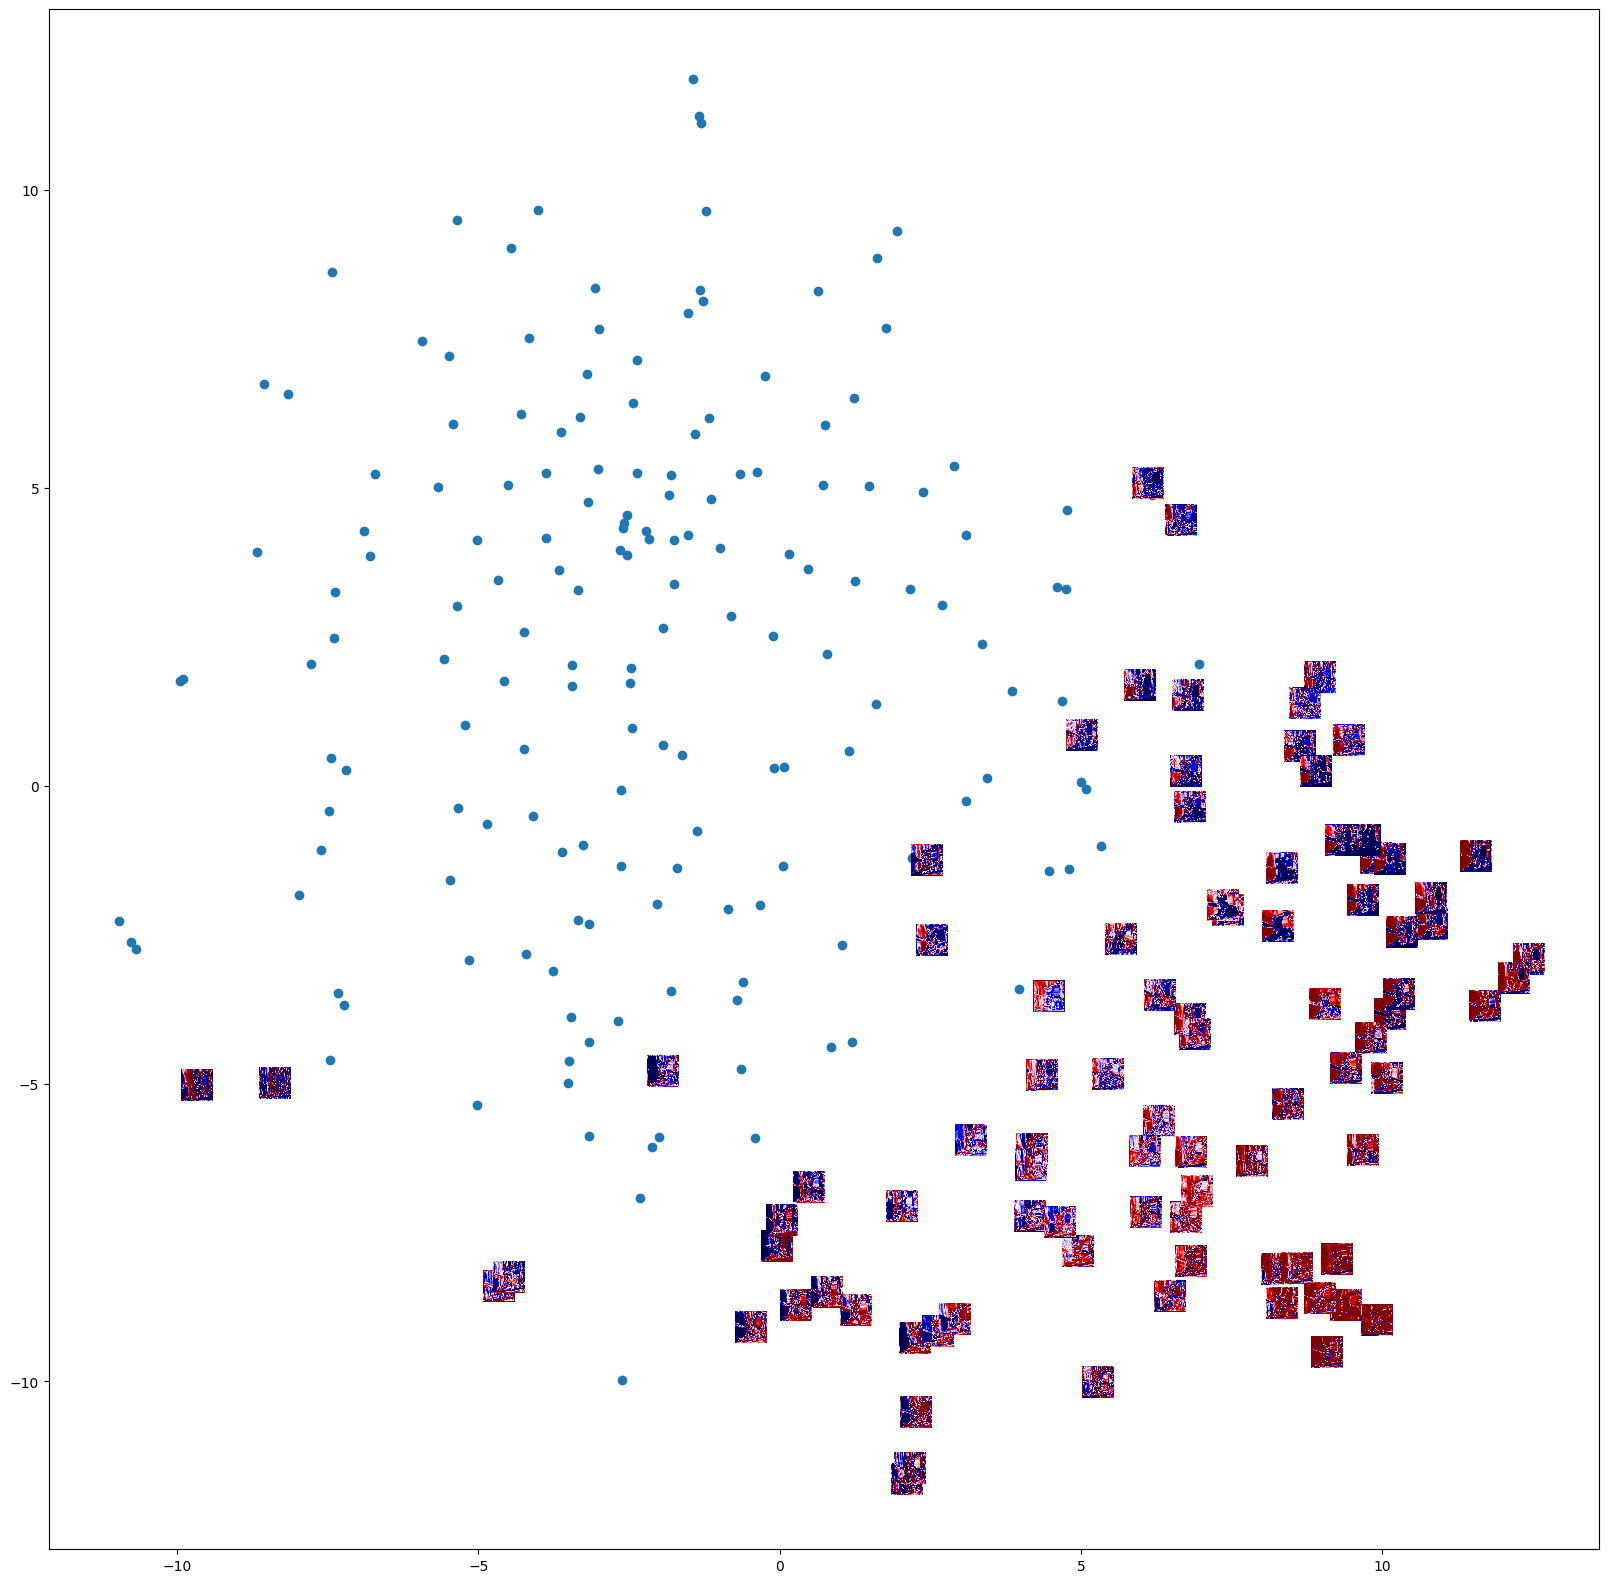

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0, perplexity=30)
tsne_res = tsne.fit_transform(train)

x = tsne_res[:,0]
y = tsne_res[:,1]

print(data.min(), data.max())

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

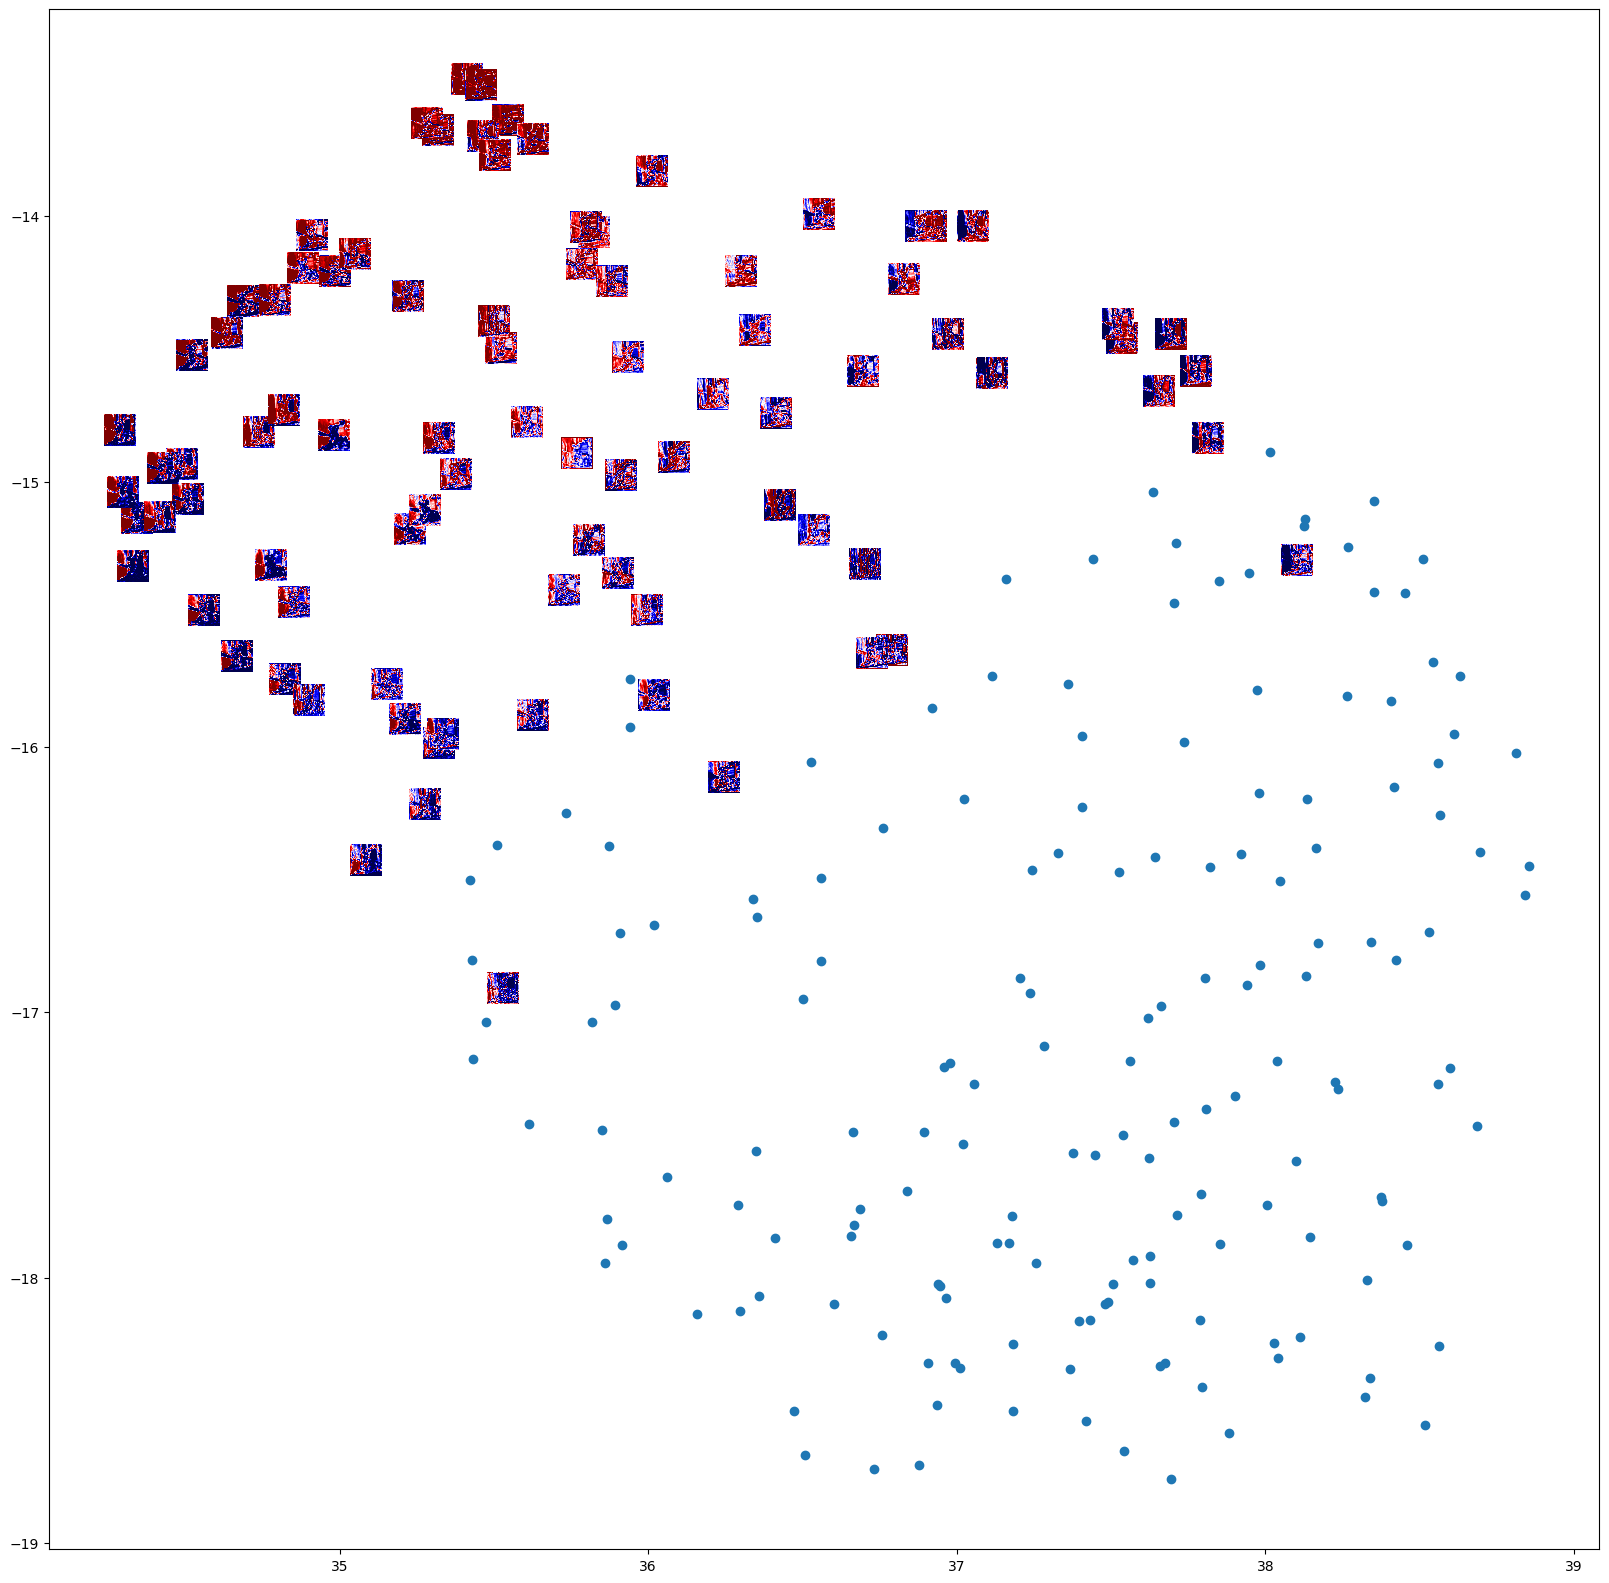

In [41]:
import umap
reducer = umap.UMAP(
    n_neighbors=50
)

umap_res = reducer.fit_transform(train)

x = umap_res[:,0]
y = umap_res[:,1]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

In [129]:
N = 100
imgs = []
activations = []
layers = list(filter(lambda l: 'conv' in l or 'mixed' in l, map(lambda l: l.name, model.layers)))
labels = []
class_ids = [245, 246]

for img, label in tqdm(ds['train'].filter(
        lambda img,label: label in class_ids
    ).map(
        lambda img,label: preprocess((img,label), size=model.input.shape[1:3].as_list())
    ).batch(
        1
    ).take(
        N
    ), total=N):
    # Get activations
    imgs.append(img)
    activation = keract.get_activations(model, img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
    activations.append(activation)
    labels.append(label)

100it [02:34,  1.54s/it]


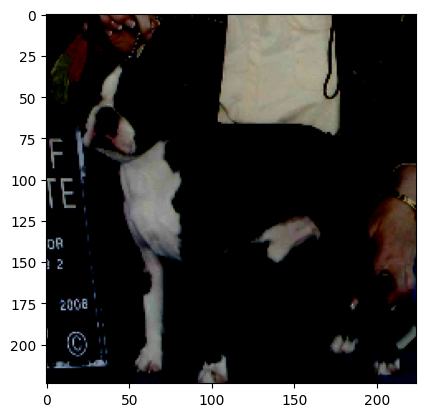

In [130]:
plt.imshow(imgs[0][0])

In [131]:
activations[0]['block1_conv1'].shape

(1, 224, 224, 64)

In [132]:
summary_fn = lambda x: np.percentile(np.abs(x), 70, axis=range(1, len(x.shape)-1))

def single_activation_distance(activation1: np.ndarray, activation2: np.ndarray):
    return np.sum(np.abs(summary_fn(activation1) - summary_fn(activation2)))

def activation_distance(activation1: dict[str,np.ndarray], activation2: dict[str,np.ndarray]):
    dist = 0
    for act1, act2 in zip(activation1.values(), activation2.values()):
        dist += single_activation_distance(act1, act2)
    return dist


In [133]:
act_dist_mat = np.zeros((len(activations), len(activations)))

for i, acti in tqdm(enumerate(activations), total=len(activations)):
    for j, actj in enumerate(activations):
        if i == j:
            act_dist_mat[i, j] = 0
            continue
        if i > j:
            continue
        act_dist_mat[i, j] = activation_distance(acti, actj)
        act_dist_mat[j, i] = act_dist_mat[i, j]

act_dist_mat

100%|██████████| 100/100 [34:17<00:00, 20.58s/it]


array([[   0.        , 2720.25829044, 3565.00856348, ..., 4691.49379199,
        3547.97588572, 4356.52797638],
       [2720.25829044,    0.        , 3136.82205501, ..., 4733.62474152,
        3190.91624488, 3776.49052934],
       [3565.00856348, 3136.82205501,    0.        , ..., 4217.26295729,
        3150.64055516, 3090.84363399],
       ...,
       [4691.49379199, 4733.62474152, 4217.26295729, ...,    0.        ,
        4756.38427093, 4524.01467723],
       [3547.97588572, 3190.91624488, 3150.64055516, ..., 4756.38427093,
           0.        , 2253.76999013],
       [4356.52797638, 3776.49052934, 3090.84363399, ..., 4524.01467723,
        2253.76999013,    0.        ]])

In [134]:
activations[0].keys()

dict_keys(['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3'])

In [135]:
imgs[0].numpy().min(), imgs[0].numpy().max()

(-0.96387863, 0.87210786)

/home/insane/.cache/pypoetry/virtualenvs/activation-pathway-bUO20rvG-py3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


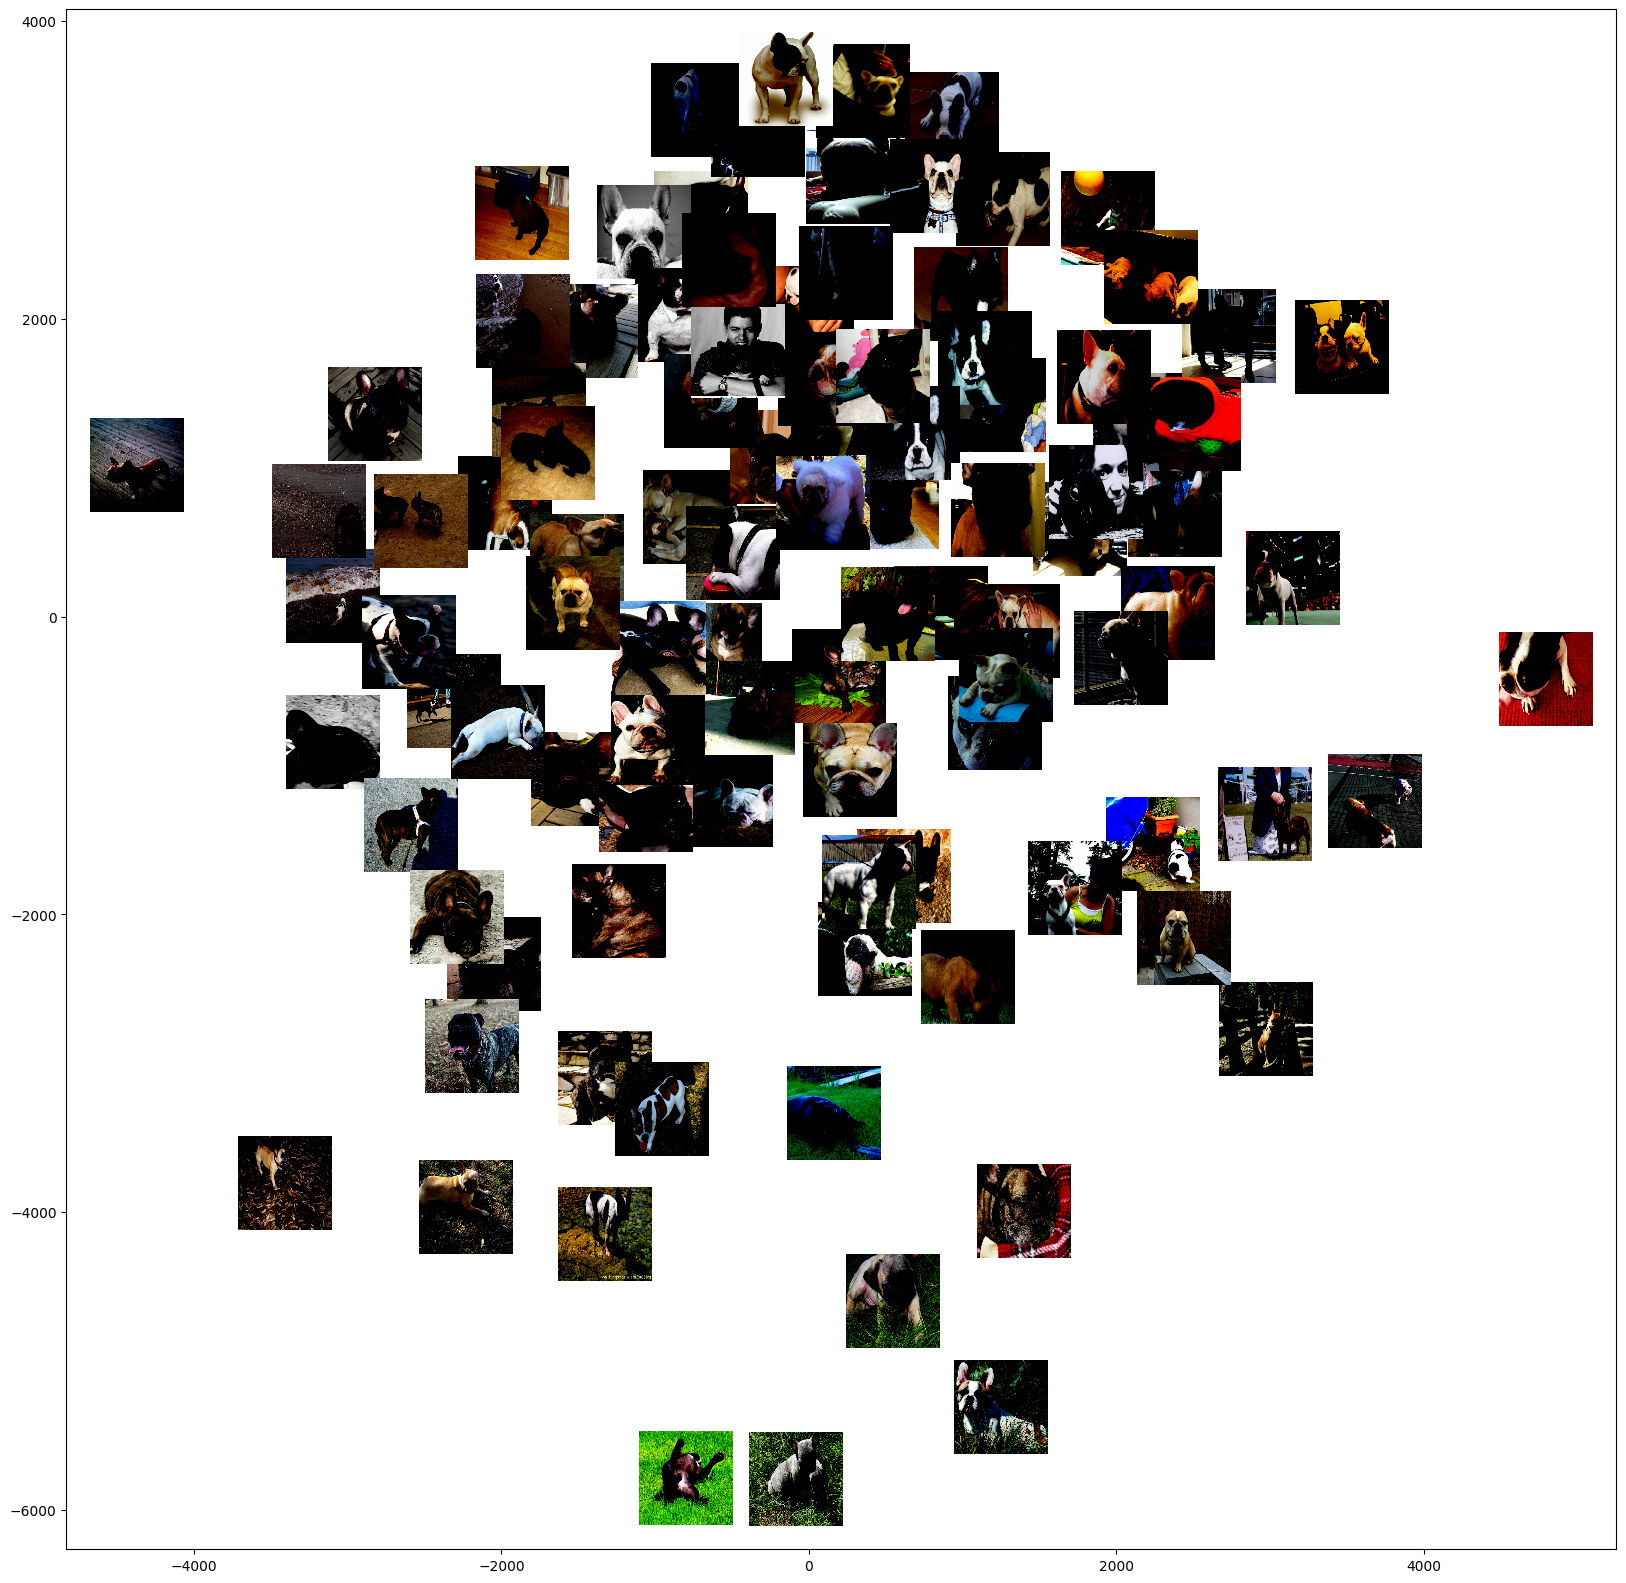

In [137]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(act_dist_mat)

coords = results.embedding_

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(coords[:, 0], coords[:, 1]) 

for i, (x0, y0) in enumerate(zip(coords[:, 0], coords[:, 1])):
    img = (imgs[i][0] + 1) * 127.6
    offsetImg = OffsetImage(imgs[i][0], zoom=.3)
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

plt.show()